In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import datetime
import json
from pprint import pprint
from IPython.core import display as ICD  # to print multiple nice pandas tables
from collections import defaultdict
import logging
import numpy as np
import io
import gensim
import tqdm
import seaborn as sns
sns.set()

In [3]:
import datasets
import classify

In [4]:
def test_model(mode, dataset, tries=10):
    results = []
    for _ in tqdm.trange(tries):
        model.fit(dataset.samples, dataset.labels)
        results.append(model.score(dataset.samples, dataset.labels))
    print(np.min(results), np.mean(results), np.max(results), np.std(results))

In [68]:
from sklearn.linear_model import LogisticRegression
from gensim.models import TfidfModel
class SimpleModel(object):
    def __init__(self, cls = None, use_tfidf=False, w=None):
        self.cls = cls
        if self.cls is None:
            self.cls = LogisticRegression()
        self.use_tfidf = use_tfidf
        self.w=w
        

    def fit(self, X, Y):
        self.dictionary = gensim.corpora.Dictionary(X)
        self.num_terms = len(self.dictionary.dfs)
        bow = list(map(self.dictionary.doc2bow, X))
        if self.use_tfidf:
            self.tfidf_model = TfidfModel(bow)
            bow = self.tfidf_model[bow]
        if self.w is None:
            self.w = np.ones(self.num_terms)
        if True:
            bow = gensim.matutils.corpus2csc(bow, num_terms=self.num_terms)
            bow = gensim.matutils.Sparse2Corpus(bow.multiply(self.w.reshape(-1,1)))
        self.lsi = gensim.models.LsiModel(bow, id2word=self.dictionary)
        self.corpus = gensim.matutils.corpus2dense(self.lsi[bow], self.lsi.num_topics).T
        self.cls.fit(self.corpus, Y)
    
    def dw(self, X, Y):
        _ = self.predict(X)
        self.d_embedding = self.cls.dx(self.embedding, Y)
        u = self.lsi.projection.u
        res = self.d_embedding.dot(u.T)
        dw = model.bow.multiply(res.T).sum(axis=1).T.A1
        return dw
        
    
    def predict(self, X):
        bow = list(map(self.dictionary.doc2bow, X))
        if self.use_tfidf:
            bow = self.tfidf_model[bow]
        if True:
            bow = gensim.matutils.corpus2csc(bow, num_terms=self.num_terms)
            self.bow = bow
            bow = bow.multiply(self.w.reshape(-1,1))
            bow = gensim.matutils.Sparse2Corpus(bow)

        self.embedding = gensim.matutils.corpus2dense(self.lsi[bow], self.lsi.num_topics).T
        Yhat = self.cls.predict(self.embedding)
        return Yhat
    
    def score(self, X, Y):
        Yhat = self.predict(X)
        return 1-((Yhat-Y)**2).mean()
    
    def update(self, X, Y):
        pass

In [69]:
len(dataset.test_samples())

378

In [70]:
len(dataset.test_labels())

378

In [71]:
dataset = datasets.CRDataset()
model = SimpleModel(classify.SkClassifier())
model.fit(dataset.train_samples(), dataset.train_labels())
print(model.score(dataset.train_samples(), dataset.train_labels()))
print(model.score(dataset.test_samples(), dataset.test_labels()))


0.7845157491904622
0.7566137566137566


In [8]:
dw = model.dw(dataset.samples, dataset.labels)
print(dw)
plt.hist(dw)

array([ 0.4669387 , -0.37677201,  0.15265691, ..., -0.00109054,
       -0.00109054, -0.00084296])

In [ ]:
alpha = 0.01
dataset = datasets.CRDataset()
model = SimpleModel(classify.SkClassifier())
model.fit(dataset.train_samples(), dataset.train_labels())
train_scores = []
test_scores = []

In [76]:
t = tqdm.trange(500)
for e in t:
    w = np.copy(model.w)
    w -= alpha * model.dw(dataset.train_samples(), dataset.train_labels())
    model = SimpleModel(classify.SkClassifier(), w=w)
    model.fit(dataset.train_samples(), dataset.train_labels())
    train_score = model.score(dataset.train_samples(), dataset.train_labels())
    test_score = model.score(dataset.test_samples(), dataset.test_labels())
    train_scores.append(train_score)
    test_scores.append(test_score)
    t.set_postfix(train_score=train_score, test_score=test_score)

100%|██████████| 500/500 [22:18<00:00,  2.68s/it, test_score=0.765, train_score=0.846]


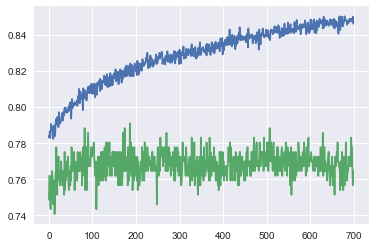

In [78]:
plt.plot(train_scores)
plt.plot(test_scores)

In [68]:
dataset = datasets.CRDataset()
model = SimpleModel(classify.SkClassifier())
model.fit(dataset.samples, dataset.labels)
model.score(dataset.samples, dataset.labels)

0.7904635761589404

In [60]:
dataset = datasets.CRDataset()
model = SimpleModel(classify.SkClassifier(), use_tfidf=True)
test_model(model, dataset)

100%|██████████| 10/10 [00:23<00:00,  2.33s/it]

0.7907284768211921 0.7958675496688743 0.7989403973509934 0.0020730063625445105


In [8]:
dataset = datasets.CRDataset()
model = SimpleModel(use_tfidf=True)
test_model(model, dataset)

100%|██████████| 10/10 [00:21<00:00,  2.11s/it]

0.7875496688741722 0.7944370860927152 0.799205298013245 0.0038842061718185775


In [9]:
dataset = datasets.CRDataset()
model = SimpleModel(use_tfidf=False)
test_model(model, dataset)

100%|██████████| 10/10 [00:19<00:00,  1.90s/it]

0.782251655629139 0.7866225165562913 0.7896688741721855 0.002686489775635024


In [10]:
dataset = datasets.CRDataset()
model = SimpleModel()
model.fit(dataset.samples, dataset.labels)
model.score(dataset.samples, dataset.labels)

0.7819867549668874

In [11]:
dataset = datasets.MPQADataset()
model = SimpleModel()
model.fit(dataset.samples, dataset.labels)
model.score(dataset.samples, dataset.labels)

0.7543843107674901

In [16]:
dataset = datasets.SUBJDataset()
model = SimpleModel()
model.fit(dataset.samples, dataset.labels)
model.score(dataset.samples, dataset.labels)

0.8861

In [28]:
from scipy.stats import logistic
import numpy as np

class Classifier(object):
    def __init__(self, alpha=0.01):
        self.alpha = alpha

    def fit(self, X, Y, epoch=1000):
        self.w = np.random.random(X.shape[1])*0.1 - 0.05
        self.b = np.random.random()*0.1 - 0.05
        for e in range(epoch):
            self.update(X, Y)
    
    def update(self, X, Y):
        h = (X*self.w).sum(axis=1) + self.b
        Yhat = logistic.cdf(h)
        dif = Yhat-Y
        sigma = dif * Yhat * (1-Yhat)
        dw = (sigma.reshape(-1,1)* X).sum(axis=0)
        db = sigma.sum()
        self.b -= db
        self.w -= dw
        
    def gradient(X, Y):
        pass
    
    def predict(self, X):
        h = (X*self.w).sum(axis=1) + self.b
        Yhat = logistic.cdf(h)
        return (Yhat>0.5)+0

In [36]:
dataset = datasets.CRDataset()
model = SimpleModel()
test_model(model, dataset)

100%|██████████| 10/10 [00:19<00:00,  1.96s/it]

0.782251655629139 0.7879205298013245 0.7909933774834437 0.0028164310166891725


In [37]:
dataset = datasets.CRDataset()
model = SimpleModel(Classifier())
test_model(model, dataset)
#model.fit(dataset.samples, dataset.labels)
#model.score(dataset.samples, dataset.labels)

100%|██████████| 10/10 [00:49<00:00,  4.92s/it]

0.6376158940397352 0.6376158940397352 0.6376158940397352 0.0
